In [1]:
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
#matplotlib.rcParams.update({'font.size': 16})

import matplotlib.pyplot as plt
pi = np.pi



In [2]:
from scipy.constants import c, mu_0, m_e, m_p
from scipy.constants import epsilon_0 as e_0
from scipy.constants import elementary_charge as q

In [3]:
import solvers
import particles
import fields
import analytic_models


# The first part of this is the field solver test 
The order of operations are as follows 
 * Eefine the parameters for the field solver test
 * Initialize the distribuiton 
 * Initializs particles  
 * Solve the fields
 * Postprocessing and plotting

In [4]:

## Particle definitions 
sigma_x = 0.05
Q = 5.0e-9
n_particles = 5000

## Field solver parameters 
L_0 = 10. * sigma_x ## Half the domain size
L_min = L_0 / 50 ## minimum wavelength to resolve

## Grid definitions for plotting 
x_max = 6 * sigma_x ## Half the plotting region
n_grid = 41
grid_index = int(n_grid / 2.) 



In [5]:
## This is where we initialize a gaussian distribuiton
distribution = particles.distribution(N = n_particles)
distribution.construct_uniform_guassian_2D(sigma_x = sigma_x, sigma_y=sigma_x)

## Particle distributions
my_gaussian_beam = particles.particles_2D_tent(distribution, 
     dx_tent = 2. * L_min, dy_tent = 2. * L_min,
    bunch_charge = Q, species_mass = m_p)

## Define the fields 
my_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0, L_x_min = L_min, L_y_min = L_min)

## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()




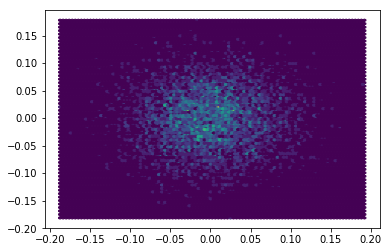

In [6]:
plt.figure()
plt.hexbin(my_gaussian_beam.x, my_gaussian_beam.y)
plt.show()

In [7]:
## Compute the potentials at the particle coordinates
field_solver.compute_phi(my_fields, my_gaussian_beam)

## Compute the potentials on a grid
field_solver.compute_phi_mesh(my_fields, xmax = x_max, ymax = x_max, n_grid = n_grid)



In [8]:
field_solver.compute_kick(my_fields, my_gaussian_beam)

/Users/jedelen/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


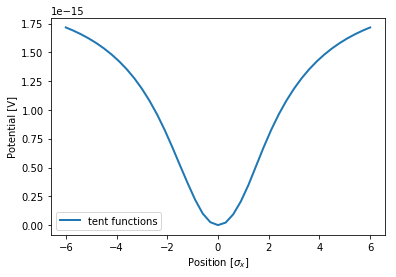

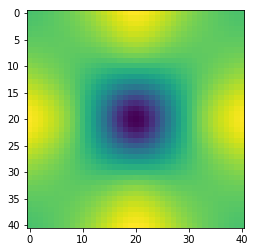

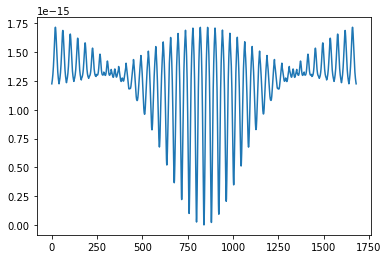

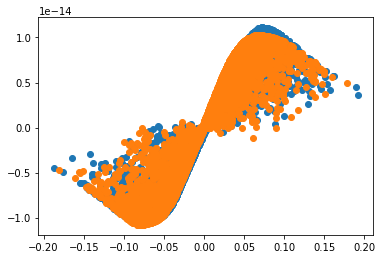

In [9]:
## post processing and  plotting 


plt.figure()

plt.plot(my_fields.y_grid[:, grid_index] / sigma_x, 
    my_fields.phi_grid[:, grid_index], label = 'tent functions', linewidth = 2.)

plt.legend(loc = 0)
plt.xlabel(r'Position [$\sigma_x$]')
plt.ylabel('Potential [V]')

plt.figure()
plt.imshow(np.real(my_fields.phi_grid))

plt.figure()
plt.plot(my_fields.phi_grid.flatten())
plt.show()

plt.figure()
plt.plot(my_gaussian_beam.x,my_fields.kick_x, 'o')
plt.plot(my_gaussian_beam.y,my_fields.kick_y, 'o')

# Next we test the particle pusher 

The workfow is the following 
* Construct a KV distribution 
* Initialize the kinetics sovler 
* Determine the simulation parameters (number of steps etc)
* Run the simulation 
* Post-process the results 

In [10]:
n_particles = 10000
L_0 = 5. * sigma_x ## Half the domain size
L_min = L_0 / 20 ## minimum wavelength to resolve

E = 5.0e6
gamma = E / 938.2720813e6 + 1.

## This is where we initialize a gaussian distribuiton
new_distribution = particles.distribution(N = n_particles)
new_distribution.construct_kv(r_0 = sigma_x, x0 = sigma_x, y0 = sigma_x)

## Particle distributions
my_kv_beam = particles.particles_2D_tent(new_distribution, dx_tent = 1. * L_min, dy_tent = 1. * L_min,
    bunch_charge = Q, species_charge = q, species_mass = m_p, gamma = gamma)

## Define the fields 
my_kv_fields = fields.cartesian_2D(L_x = L_0, L_y = L_0,
	L_x_min = L_min, L_y_min = L_min)


In [11]:

## This is where we instantiate the solver
field_solver = solvers.field_solver_2D()

# instantiate the kinetics solver
kinetics_solver = solvers.kinetics_solver_SC2D(ds = 1.0e-1)




In [12]:
## The first test is to compute the potential and the kicks 
field_solver.compute_phi(my_kv_fields, my_kv_beam)

field_solver.compute_kick(my_kv_fields, my_kv_beam)

field_solver.compute_phi_mesh(my_kv_fields, xmax = sigma_x, ymax = sigma_x, n_grid = n_grid)

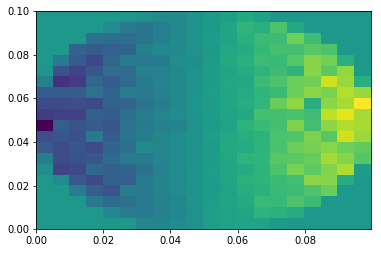

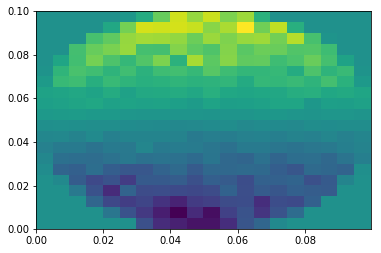

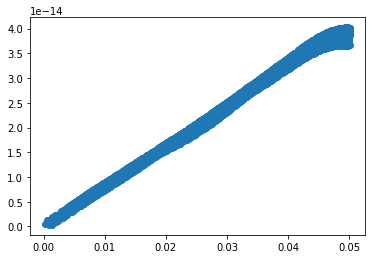

In [13]:
plt.figure()
plt.hist2d(my_kv_beam.x, my_kv_beam.y, weights = my_kv_fields.kick_x, bins = 20)

plt.figure()
plt.hist2d(my_kv_beam.x, my_kv_beam.y, weights = my_kv_fields.kick_y, bins = 20)

x0 = np.mean(my_kv_beam.x)
y0 = np.mean(my_kv_beam.y)
r = np.sqrt((my_kv_beam.x  - x0)** 2 + (my_kv_beam.y - y0) **2)
kick_r = np.sqrt(my_kv_fields.kick_y **2 + my_kv_fields.kick_x **2)

plt.figure()
plt.plot(r,kick_r,'o')
plt.show()

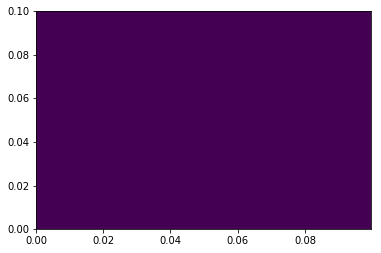

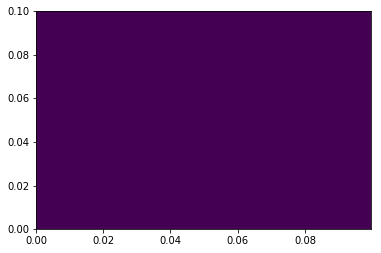

In [14]:
plt.figure()
plt.hist2d(my_kv_beam.x, my_kv_beam.y, weights = my_kv_beam.px, bins = 20)

plt.figure()
plt.hist2d(my_kv_beam.x, my_kv_beam.y, weights = my_kv_beam.py, bins = 20)
plt.show()


In [15]:


kinetics_solver.step(my_kv_beam, my_kv_fields, field_solver)

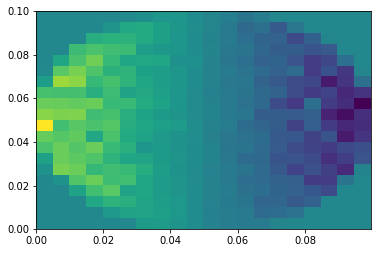

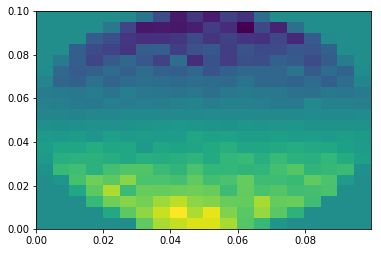

In [19]:
plt.figure()
plt.hist2d(my_kv_beam.x, my_kv_beam.y, weights = my_kv_beam.px, bins = 20)

plt.figure()
plt.hist2d(my_kv_beam.x, my_kv_beam.y, weights = my_kv_beam.py, bins = 20)
plt.show()


In [17]:
r_max = []
k = 0
while k < 100:

    kinetics_solver.step(my_kv_beam, my_kv_fields, field_solver)
    
    x0 = np.mean(my_kv_beam.x)
    y0 = np.mean(my_kv_beam.y)
    r = np.sqrt((my_kv_beam.x  - x0)** 2 + (my_kv_beam.y - y0) **2)
    r_max.append(np.max(r))
    k = k + 1


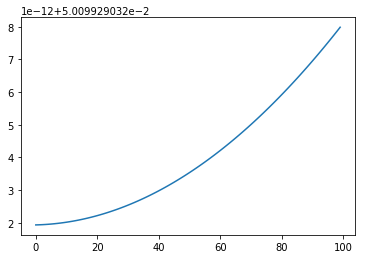

In [18]:
plt.figure()
plt.plot(r_max)
plt.show()